In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from matplotlib import colors, cm
import glob
from datetime import datetime, timedelta

from numba import njit, vectorize, float32

from typing import Callable, Optional, Union, List

import hoomd
import gsd.hoomd
import freud
import schmeud
from schmeud._schmeud import dynamics as schmeud_dynamics

import sys
import time
import pickle
import gc
import warnings
import copy
import pathlib
from collections import defaultdict

import os
import sys

import signac

from dataclasses import dataclass
from dataclasses_json import dataclass_json

import fresnel
import PIL.Image

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# get jobs

# loop over SF timesteps

# run isoconfig runs and collect dynamic information
mpl.rcParams["figure.dpi"] = 150
mpl.rcParams["axes.labelsize"] = "xx-large"
from monk import nb, prep, pair, render, utils, workflow, grid

config = workflow.get_config()
project: signac.Project = signac.get_project(root=config['root'])
project.doc

In [8]:
for job in project.find_jobs({"delta": 0, "replica": 0}, {"_CRYSTAL": {"$exists": False}}):

    delta = 0.0
    path = sorted(glob.glob(job.fn("short_runs/temp-*/")))[8]
    temp = float(utils.extract_between(path, "temp-", "/"))
    path = pathlib.Path(path)

In [9]:
path

PosixPath('/media/ian/Data2/monk/mlj-production/workspace/1fd668d1992cea34bb8de5b9cf4bc990/short_runs/temp-0.64')

In [10]:
traj = path / "traj.gsd"
dt = 1e-2

In [11]:
seed = 100
print("Initialize HOOMD simulation")
device = hoomd.device.GPU()
sim = hoomd.Simulation(device=device, seed=seed)
print(f"Running on {device.devices[0]}")

Initialize HOOMD simulation
Running on [0]NVIDIA GeForce RTX 2080  46 SM_7.5 @ 1.71 GHz, 7971 MiB DRAM


In [12]:
traj.as_posix()

'/media/ian/Data2/monk/mlj-production/workspace/1fd668d1992cea34bb8de5b9cf4bc990/short_runs/temp-0.64/traj.gsd'

In [13]:
sim.create_state_from_gsd(traj.as_posix())

integrator = hoomd.md.Integrator(dt=dt)
cell = hoomd.md.nlist.Cell(0.2)
lj = pair.KA_LJ(cell)
integrator.forces.append(lj)

nvt = hoomd.md.methods.NVT(
    kT=temp,
    filter=hoomd.filter.All(),
    tau=0.5)
integrator.methods.append(nvt)
sim.operations.integrator = integrator

sim.state.thermalize_particle_momenta(filter=hoomd.filter.All(), kT=temp)


In [14]:
# Custom hoomd triggers and actions

class AsyncTrigger(hoomd.trigger.Trigger):
    """NOT async in the Rust or JavaScript way
    
    Trigger by calling the activate() method"""

    def __init__(self):
        self.async_trig = False
        hoomd.trigger.Trigger.__init__(self)

    def activate(self):
        self.async_trig = True

    def compute(self, timestep):
        out = self.async_trig
        self.async_trig = False
        return out

class RestartablePeriodicTrigger(hoomd.trigger.Trigger):

    def __init__(self, period):
        assert(period >= 1)
        self.period = period
        self.state = period - 1
        hoomd.trigger.Trigger.__init__(self)

    def reset(self):
        self.state = self.period - 1

    def compute(self, timestep):
        if self.state >= self.period - 1:
            self.state = 0
            return True
        else:
            self.state += 1
            return False


class UpdatePos(hoomd.custom.Action):
    """Custom action to handle feeding in a new set of positions through a snapshot"""

    def __init__(self, new_snap=None):
        self.new_snap = new_snap

    def set_snap(self, new_snap):
        self.new_snap = new_snap

    def act(self, timestep):
        old_snap = self._state.get_snapshot()
        if old_snap.communicator.rank == 0:
            N = old_snap.particles.N
            new_velocity = np.zeros((N,3))
            for i in range(N):
                old_snap.particles.velocity[i] = new_velocity[i]
                old_snap.particles.position[i] = self.new_snap.particles.position[i]
        self._state.set_snapshot(old_snap)

class PastSnapshotsBuffer(hoomd.custom.Action):
    """Custom action to hold onto past simulation snapshots"""

    def __init__(self):
        self.snap_buffer = []

    def clear(self):
        self.snap_buffer.clear()

    def get_snapshots(self):
        return self.snap_buffer

    def force_push(self):
        self.act(None)

    def act(self, timestep):
        snap = self._state.get_snapshot()
        self.snap_buffer.append(snap)


In [15]:
snap = sim._state.get_snapshot()

In [16]:
from schmeud.dynamics import thermal
import pandas as pd

In [17]:
replicas = 100
steps_per_dump = 10
total_steps = 1000

In [18]:

custom_updater = UpdatePos(new_snap=snap)
snap_buffer = PastSnapshotsBuffer()
reset_config_trig = AsyncTrigger()
snap_buffer_trig = RestartablePeriodicTrigger(steps_per_dump)

custom_op = hoomd.update.CustomUpdater(action=custom_updater,
                                       trigger=reset_config_trig)

another_op = hoomd.update.CustomUpdater(action=snap_buffer,
                                        trigger=snap_buffer_trig)

In [19]:
sim.operations.add(custom_op)
sim.operations.add(another_op)

sim.run(0)

In [22]:
all_phops = []

# snap_buffer.clear()

# iterate over traj frames
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=DeprecationWarning)
    for idx in range(replicas):
        if idx%10 == 0:
            print("Frame", 0, "\n--> Replica", idx)
        reset_config_trig.activate()
        snap_buffer_trig.reset()
        sim.run(2)
        nvt.thermalize_thermostat_dof()

        
        # print(sim.timestep)

        sim.run(total_steps+2)

        # print(sim.timestep)

        # process phop
        mtraj = snap_buffer.get_snapshots()
        phop = thermal.calc_phop(mtraj, tr_frames=len(mtraj)-1)

        all_phops.append([np.arange(len(phop[0]), dtype=np.uint32), np.uint32(idx), phop[0].astype(np.float32)]) # trivial unwrapping

        snap_buffer.clear()

df = pd.DataFrame(all_phops, columns=["id", "replica", "phop"]).explode(["id", "phop"])

Frame 0 
--> Replica 0
Frame 0 
--> Replica 10
Frame 0 
--> Replica 20
Frame 0 
--> Replica 30
Frame 0 
--> Replica 40
Frame 0 
--> Replica 50
Frame 0 
--> Replica 60
Frame 0 
--> Replica 70
Frame 0 
--> Replica 80
Frame 0 
--> Replica 90


In [23]:
df.to_parquet(f"test-isoconfig-phop_temp-{temp}.parquet")

In [ ]:
df = pd.read_parquet(f"test-isoconfig-phop_temp-{temp}.parquet")

In [21]:
snap_buffer.clear()

In [ ]:
print(len(mtraj))

In [ ]:
snap_buffer.snap_buffer

In [24]:
df.head()

,id,replica,phop
0,0,0,0.073346
0,1,0,0.060528
0,2,0,0.053758
0,3,0,0.210195
0,4,0,0.032788


In [25]:
df.isna().any()

id         False
replica    False
phop       False
dtype: bool

In [26]:
def rearrange(df):
    # N = len(df)
    tmp = df.phop > 0.2
    return tmp.mean()

In [27]:
tmp = df.groupby("id").apply(rearrange)

In [28]:
tmp.head()

id
0    0.06
1    0.04
2    0.12
3    0.10
4    0.07
dtype: float64

In [29]:
temp

0.64

In [30]:
struct_df = pd.read_parquet((path / "sfs.parquet").as_posix())

In [31]:
sdf = struct_df[struct_df["frame"] == 0]
sdf = sdf[sdf["type"] == 0]
tags = sdf["tag"].to_numpy()

In [32]:
tags

array([    0,     1,     2, ..., 32765, 32766, 32767])

In [33]:
len(tmp)

32768

In [34]:
tmp

id
0        0.06
1        0.04
2        0.12
3        0.10
4        0.07
         ... 
32763    0.10
32764    0.14
32765    0.08
32766    0.10
32767    0.11
Length: 32768, dtype: float64

In [35]:
tmp = tmp.iloc[tags]

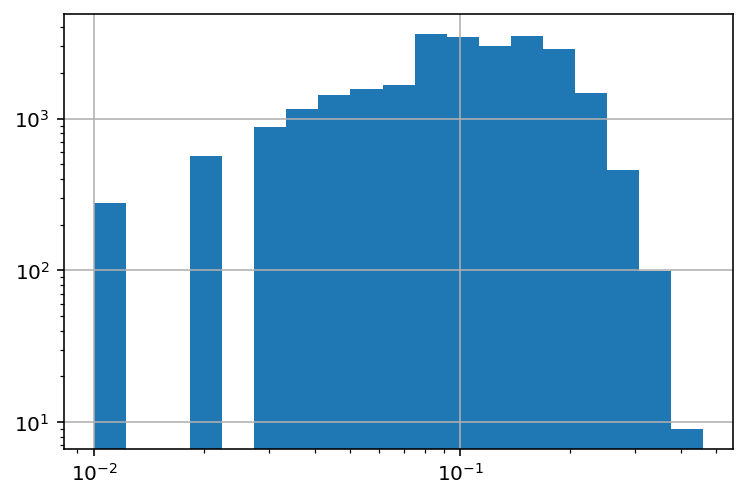

In [36]:
tmp.hist(bins=np.geomspace(1e-2, tmp.max(), 20))
plt.xscale('log')
plt.yscale('log')

In [38]:
len(np.where(tmp == 0.0)[0])

26133

In [39]:
adf = df[df.replica < 5]

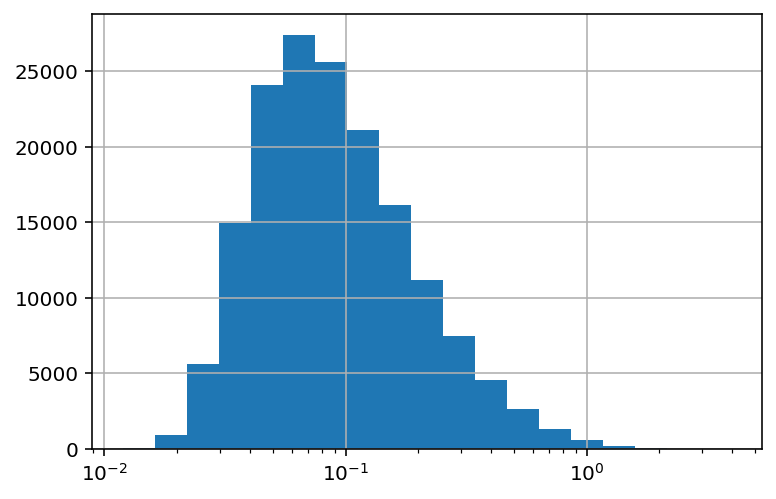

In [41]:
adf["phop"].hist(bins=np.geomspace(adf["phop"].min(), adf["phop"].max(), 20))
plt.xscale('log')
# plt.yscale('log')

In [42]:
def local_rdf_binary_density(r, sf, dr):
    vol = 4/3*np.pi*(r[-1]**3)
    inv_shell = 1/(4*np.pi*(r**2)*dr)
    na = np.sum(sf[::2])
    nb = np.sum(sf[1::2])
    n = na + nb
    inv_na = 1/na
    inv_nb = 1/nb
    g_a = sf[::2]*inv_shell*inv_na*vol
    g_b = sf[1::2]*inv_shell*inv_nb*vol
    return np.concatenate([g_a, g_b/4.0])

def compute_rdf(df, groups):
    s2 = []
    r = np.linspace(0.4, 3.0, 27)
    dr = r[1] - r[0]
    N = 0
    for group in groups:
        print(group)
        sf = df.iloc[group].sf.mean()
        N += len(group)
        s2.append(local_rdf_binary_density(r, sf, dr))
        
    return s2

In [43]:
r = np.linspace(0.4, 3.0, 27)
dr = r[1] - r[0]

In [51]:
ndf = pd.DataFrame()
ndf["sf"] = [local_rdf_binary_density(r, sf, dr) for sf in sdf["sf"].to_numpy()]
ndf["phop"] = tmp.to_numpy()

ndf = ndf.sample(1000)

cmap = cm.jet
norm = colors.LogNorm(vmin=1e-2, vmax=ndf["phop"].max())

S_color = cmap(norm(ndf["phop"].to_numpy()))
X = np.stack(ndf["sf"].to_numpy())

In [45]:
ndf.isna().any()

sf      False
phop    False
dtype: bool

<AxesSubplot:>

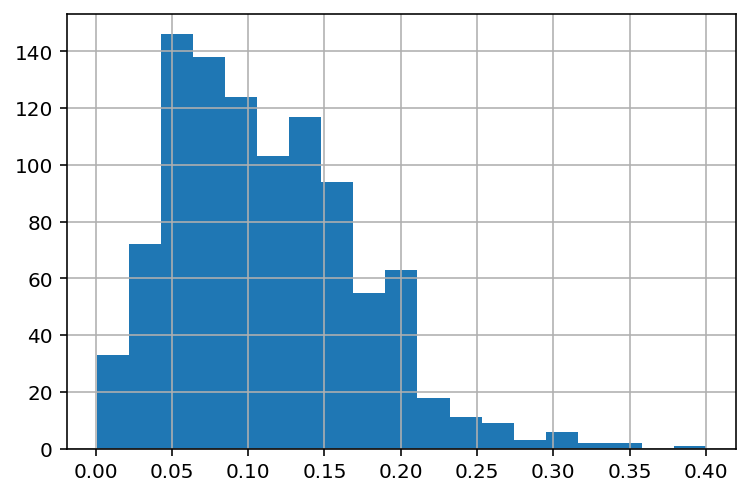

In [46]:
ndf.phop.hist(bins=np.linspace(ndf.phop.min()+1e-3, ndf.phop.max(), 20))
# plt.xscale('log')

In [49]:
from sklearn.manifold import TSNE, LocallyLinearEmbedding, Isomap, MDS, SpectralEmbedding

### Plotting functions

In [47]:
from matplotlib import ticker

import mpl_toolkits.mplot3d  # noqa: F401

def plot_3d(points, points_color, title):
    x, y, z = points.T

    fig, ax = plt.subplots(
        figsize=(6, 6),
        facecolor="white",
        tight_layout=True,
        subplot_kw={"projection": "3d"},
    )
    fig.suptitle(title, size=16)
    col = ax.scatter(x, y, z, c=points_color, s=50, alpha=0.8)
    ax.view_init(azim=-60, elev=9)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.zaxis.set_major_locator(ticker.MultipleLocator(1))

    fig.colorbar(col, ax=ax, orientation="horizontal", shrink=0.6, aspect=60, pad=0.01)
    plt.show()

def plot_3d_view(points, points_color, title, azim=-60, elev=9):
    x, y, z = points.T

    fig, ax = plt.subplots(
        figsize=(6, 6),
        facecolor="white",
        tight_layout=True,
        subplot_kw={"projection": "3d"},
    )
    # ax = mpl_toolkits.mplot3d.Axes3D(fig)
    fig.suptitle(title, size=16)
    col = ax.scatter(x, y, z, c=points_color, s=50, alpha=0.8)
    ax.view_init(azim=azim, elev=elev)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.zaxis.set_major_locator(ticker.MultipleLocator(1))

    fig.colorbar(col, ax=ax, orientation="horizontal", shrink=0.6, aspect=60, pad=0.01)


def plot_2d(points, points_color, title):
    fig, ax = plt.subplots(figsize=(3, 3), facecolor="white", constrained_layout=True)
    fig.suptitle(title, size=16)
    add_2d_scatter(ax, points, points_color)
    plt.show()


def add_2d_scatter(ax, points, points_color, title=None):
    x, y = points.T
    ax.scatter(x, y, c=points_color, s=50, alpha=0.8)
    ax.set_title(title)
    ax.xaxis.set_major_formatter(ticker.NullFormatter())
    ax.yaxis.set_major_formatter(ticker.NullFormatter())

### TSNE 3D

In [52]:
X_embedded = TSNE(n_components=3, learning_rate='auto',
                  init='random', perplexity=30, n_iter=10_000).fit_transform(X)

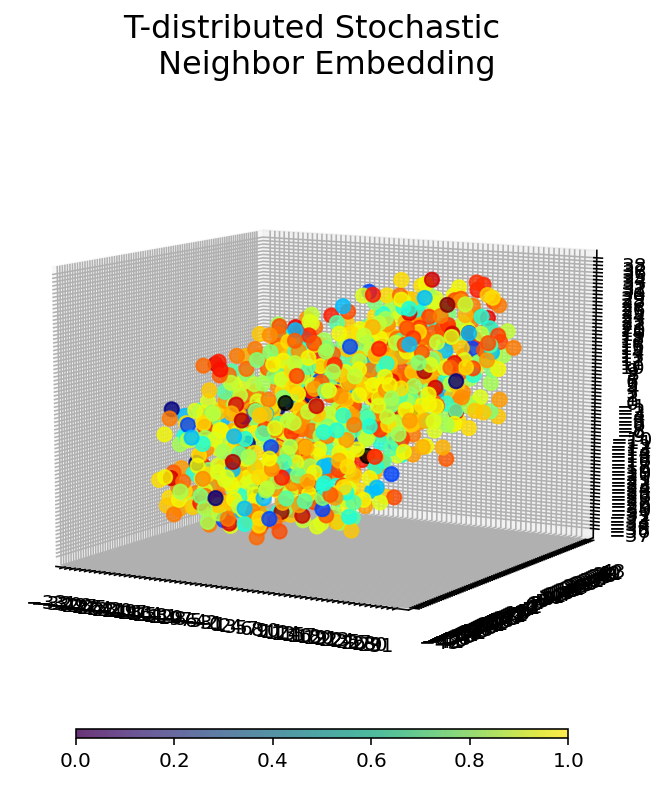

In [53]:
plot_3d(X_embedded, S_color, "T-distributed Stochastic  \n Neighbor Embedding")

### TSNE 2D

In [54]:
X_embedded = TSNE(n_components=2, learning_rate='auto', early_exaggeration=100,
                  init='random', perplexity=30, n_iter=10_00).fit_transform(X)

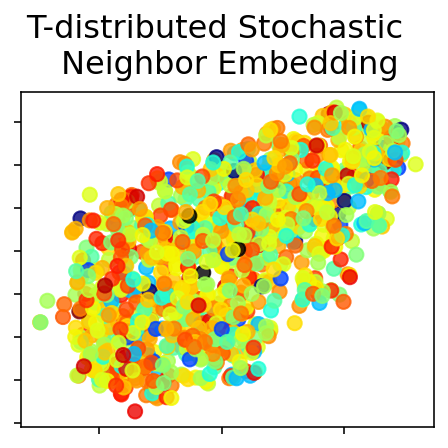

In [55]:
plot_2d(X_embedded, S_color, "T-distributed Stochastic  \n Neighbor Embedding")

### LTSA 3D

In [56]:
embedding = LocallyLinearEmbedding(n_components=3, n_neighbors=5)
X_transformed = embedding.fit_transform(X)

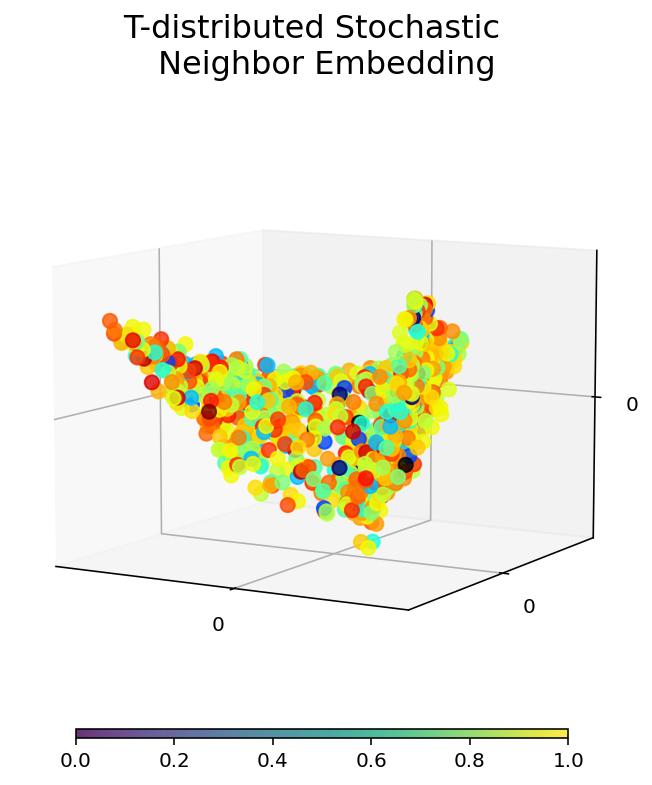

In [57]:
plot_3d(X_transformed, S_color, "T-distributed Stochastic  \n Neighbor Embedding")

### LTSA 2D

In [81]:
embedding = LocallyLinearEmbedding(n_components=2, n_neighbors=5)
X_transformed = embedding.fit_transform(X)

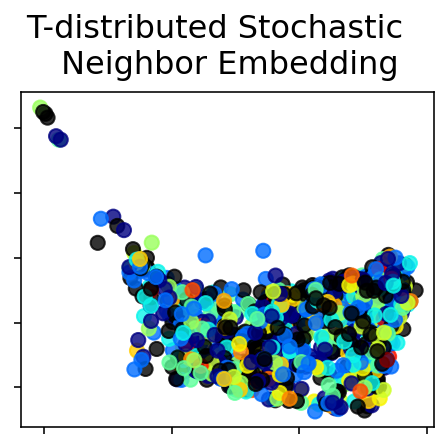

In [82]:
plot_2d(X_transformed, S_color, "T-distributed Stochastic  \n Neighbor Embedding")

### Isomap 3D

In [ ]:
embedding = Isomap(n_components=2)
X_transformed = embedding.fit_transform(X)

In [ ]:
plot_2d(X_transformed, S_color, "T-distributed Stochastic  \n Neighbor Embedding")

### MDS 3D

In [ ]:
embedding = MDS(n_components=3)
X_transformed = embedding.fit_transform(X)

In [ ]:
plot_3d(X_transformed, S_color, "MDS 3D")

### Spectral Embedding

In [ ]:
spectral = SpectralEmbedding(n_components=3)
X_transformed = spectral.fit_transform(X)

In [ ]:
plot_3d(X_transformed, S_color, "T-distributed Stochastic  \n Neighbor Embedding")

### UMAP

In [ ]:
import umap

In [ ]:
reducer = umap.UMAP(n_components=3)
X_transformed = reducer.fit_transform(X)

In [ ]:
plot_3d_view(X_transformed, S_color, "T-distributed Stochastic  \n Neighbor Embedding", azim=180, elev=10)

In [ ]:
r

In [ ]:
plot_2d(X_transformed, S_color, "T-distributed Stochastic  \n Neighbor Embedding")